In [ ]:
!pip install tensorflow_datasets

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras import Model

## Load the data

In [ ]:
#Load the tf_flowers dataset and split training/validation/test set.
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers', # Name of the dataset to load.
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], # Split to training, validation and test set.
    with_info=True, # Return the dataset information and keep in 'metadata' variable.
    as_supervised=True,  # boolean, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label)
)

# Show the data information (metadata)
print("Metadata: " +str(metadata))

# Show the number of classes of the dataset
num_classes = metadata.features['label'].num_classes
print("Number of classes: " + str(num_classes))

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Metadata: tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1.incompleteH45BQO',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflo

##Process, normalize and resize the images

(1, 333, 500, 3) tf.Tensor([2], shape=(1,), dtype=int64) tulips
(1, 212, 320, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers
(1, 240, 320, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers
(1, 240, 320, 3) tf.Tensor([4], shape=(1,), dtype=int64) roses
(1, 317, 500, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers


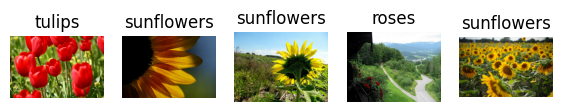

In [ ]:
#Show data samples from the training set
get_label_name = metadata.features['label'].int2str
train_iter = iter(train_ds)
fig = plt.figure(figsize=(7, 8))
for x in range(5):
  image, label = next(train_iter)
  fig.add_subplot(1, 5, x+1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(get_label_name(label))

# Print some of image tensors
count = 0
for image, label in train_ds.batch(batch_size=1):
  if (count < 5):
    print(image.shape, label, get_label_name(label[0])) # Show image tensor information. See that the image tensors vary in size.
    count = count + 1

(1, 333, 500, 3) tf.Tensor([2], shape=(1,), dtype=int64) tulips
(1, 212, 320, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers
(1, 240, 320, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers
(1, 240, 320, 3) tf.Tensor([4], shape=(1,), dtype=int64) roses
(1, 317, 500, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers


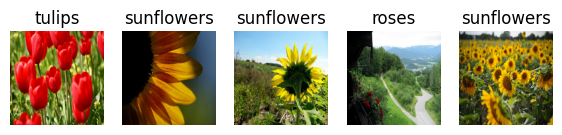

In [ ]:
#Data processing with resizing and rescaling
IMG_SIZE = 180
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE), # Resize the image to a fixed size
  tf.keras.layers.Rescaling(1./255) # Normalize pixel values
])

#Show data sample after processing
train_iter = iter(train_ds)
fig = plt.figure(figsize=(7, 8))
for x in range(5):
  image, label = next(train_iter)
  fig.add_subplot(1, 5, x+1)
  result = resize_and_rescale(image)
  plt.imshow(result)
  plt.axis('off')
  plt.title(get_label_name(label))

# Print some of image tensors after processing
count = 0
for image, label in train_ds.batch(batch_size=1):
  if (count < 5):
    print(image.shape, label, get_label_name(label[0])) # Show image tensor information. See that the image tensors vary in size.
    count = count + 1

##Build a CNN architecture

###Data Augmentation


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
# Prepare the data: resize and scale, then augment.
def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale the dataset 'ds'.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=tf.data.AUTOTUNE) # Number data samples to process asynchronously in parallel at a time.

  # shuffle=False by default
  if shuffle:
    ds = ds.shuffle(buffer_size=1000)

  # Get a batch_size of data samples from the dataset 'ds'.
  ds = ds.batch(batch_size=1024)

  # augment=False by default
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)

  # Prepare the data in the buffer.
  # When tf.data.AUTOTUNE is used, the buffer size is dynamically tuned.
  return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Resize and rescale the training set; shuffle and augment it.
train_ds = prepare(train_ds, shuffle=True, augment=True)

# Resize and rescale the validation set; DO NOT shuffle and augment it.
val_ds = prepare(val_ds)

# Resize and rescale the test set; DO NOT shuffle and augment it.
test_ds = prepare(test_ds)

Image shape:  (180, 180, 3)


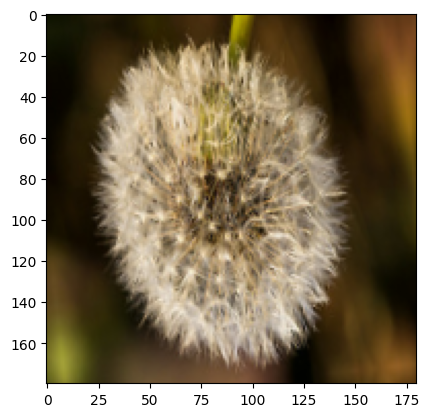

Image shape:  (180, 180, 3)


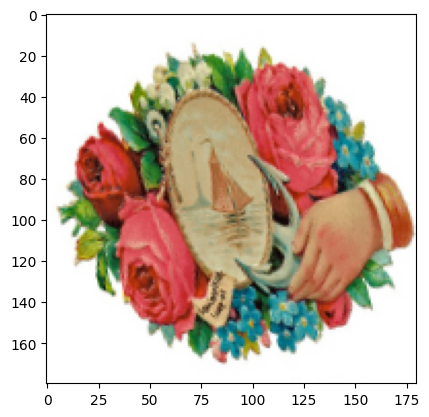

In [ ]:
# Plot some data samples in the training data after processing
count = 0
for image_batch in tfds.as_numpy(train_ds):
  if count < 2:
    print("Image shape: ", image_batch[0][count].shape)
    plt.imshow(image_batch[0][count])
    plt.show()
  count = count + 1

###Model Training with Inception V3 and Transfer Learning

In [ ]:
#Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
pre_trained_model = InceptionV3(input_shape = (IMG_SIZE, IMG_SIZE, 3),
                                include_top = False,
                                weights = 'imagenet')

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
# Print model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 89, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
#Take the layers including and above "mixed7"
last_layer = pre_trained_model.get_layer('mixed7').output

In [ ]:
# Add classification layers on top of it
x = Flatten()(last_layer) # Convert the last layer to a 1D tensor.
x= BatchNormalization()(x) # Add batch normalization layer.
x = Dense(64, activation='relu')(x) # Add a fully connected layer.
x = Dense(64, activation='relu')(x) # Add a fully connected layer.
x = Dropout(0.5)(x) # Add a dropout layer with probability 0.5.
pred = Dense(num_classes, activation='softmax')(x) # Add a fully connected layer with softmax activation function as the prediction output.

# Define a new model by grouping layers into an object with training and inference features.
complete_model_inception_v3 = Model(inputs=pre_trained_model.input, outputs=pred)

# Print model summary. See the changes in the model structure and the number of trainable parameters.
complete_model_inception_v3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 89, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

##Train and validate the model

In [ ]:
##### Reinitialize the network, i.e., wipe out all trained weights from the previous blocks of code.
# Initialize the model inception_v3 from tf.keras.applications
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet', # None for random initialization, or 'imagenet' for using pre-training on ImageNet.
    include_top=False, # Whether to include the fully-connected layers at the top of the network.
    input_shape=(IMG_SIZE, IMG_SIZE, 3)) # Specify input input_shape

# Extract the last layers from mixed7 to above
last_layer = pre_trained_model.get_layer('mixed7').output

# Add classification layers on top of it
x = Flatten()(last_layer) # Convert the last layer to a 1D tensor.
x= BatchNormalization()(x) # Add batch normalization layer.
x = Dense(64, activation='relu')(x) # Add a fully connected layer.
x = Dense(64, activation='relu')(x) # Add a fully connected layer.
x = Dropout(0.5)(x) # Add a dropout layer with probability 0.5.
pred = Dense(num_classes, activation='softmax')(x) # Add a fully connected layer with softmax activation function as the prediction output.
##########

# Define a new model by grouping layers into an object with training and inference features.
complete_model_inception_v3 = Model(inputs=pre_trained_model.input, outputs=pred)

# Freeze the base model (feature extraction layers)
pre_trained_model.trainable = False

# Define a new model by grouping layers into an object with training and inference features.
complete_model_inception_v3_freeze = Model(inputs=pre_trained_model.input, outputs=pred)

# Print model summary. See the changes in the model structure and the number of trainable parameters.
complete_model_inception_v3_freeze.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 89, 89, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_95 (BatchN  (None, 89, 89, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
# Compile the model
complete_model_inception_v3_freeze.compile(optimizer='adam', # Use Adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Labels are integer encoded, for example, [1] , [2] and [3] for 3-class problem.
              metrics=['accuracy']) # Model evaluation metric.

In [ ]:
# Set training epochs and batch size
training_epochs=10
training_batch_size=512

# Train the model
history_freeze = complete_model_inception_v3_freeze.fit(
  train_ds,
  validation_data=val_ds,
  epochs=training_epochs,
  batch_size=training_batch_size
)

Epoch 1/10
3/3 [==============================] - 63s 12s/step - loss: 1.8332 - accuracy: 0.3854 - val_loss: 0.9948 - val_accuracy: 0.6152
Epoch 2/10
3/3 [==============================] - 14s 2s/step - loss: 1.1822 - accuracy: 0.6734 - val_loss: 0.7862 - val_accuracy: 0.7368
Epoch 3/10
3/3 [==============================] - 14s 2s/step - loss: 0.9890 - accuracy: 0.7287 - val_loss: 0.6837 - val_accuracy: 0.7659
Epoch 4/10
3/3 [==============================] - 14s 2s/step - loss: 0.8803 - accuracy: 0.7676 - val_loss: 0.6299 - val_accuracy: 0.7949
Epoch 5/10
3/3 [==============================] - 13s 2s/step - loss: 0.7493 - accuracy: 0.7855 - val_loss: 0.6086 - val_accuracy: 0.8004
Epoch 6/10
3/3 [==============================] - 13s 2s/step - loss: 0.7187 - accuracy: 0.7960 - val_loss: 0.5857 - val_accuracy: 0.8131
Epoch 7/10
3/3 [==============================] - 15s 2s/step - loss: 0.6673 - accuracy: 0.8077 - val_loss: 0.5723 - val_accuracy: 0.8113
Epoch 8/10
3/3 [=================

##Evaluate performance on test set

In [ ]:
chosen_model = complete_model_inception_v3_freeze

# Evaluate the model accuracy using the function model.evaluate()
model_eval = chosen_model.evaluate(train_ds)
print("List of metrics" + str(chosen_model.metrics_names)) # List of possible metrics of the model evaluation, this is the metrics specified in the model.compile().

print("Test loss: " + str(model_eval[0])) # Test loss
print("Test accuracy: " + str(model_eval[1])) # Test accuracy

3/3 [==============================] - 13s 2s/step - loss: 0.5298 - accuracy: 0.8583
List of metrics['loss', 'accuracy']
Test loss: 0.5298117399215698
Test accuracy: 0.8583106398582458


##Visualize model behavior

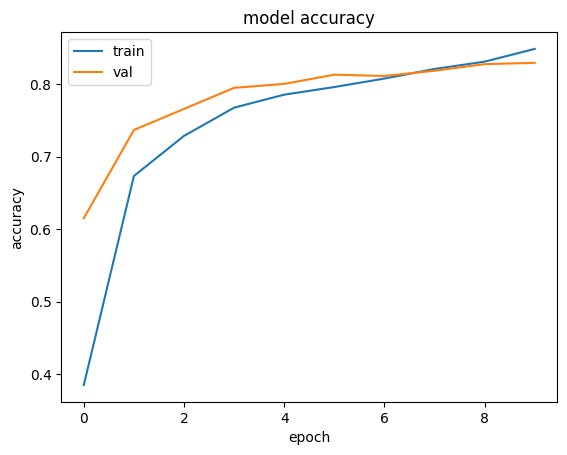

In [ ]:
# Visualize the training and validation accuracy over epochs
plt.plot(history_freeze.history['accuracy'])
plt.plot(history_freeze.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()